# DINO Visualize Self-Attention Sample
https://github.com/facebookresearch/dino<br/>
https://arxiv.org/abs/2104.14294

In [1]:
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np
from PIL import Image

In [2]:
patch_size = 8
#model = torch.hub.load('facebookresearch/dino:main', 'dino_deits8')
model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')

Downloading: "https://github.com/facebookresearch/dino/archive/main.zip" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_deitsmall16_pretrain.pth


  0%|          | 0.00/82.7M [00:00<?, ?B/s]

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

for p in model.parameters():
        p.requires_grad = False
        
model.eval()
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (

## Input Image

<class 'PIL.Image.Image'>
(480, 480, 3)


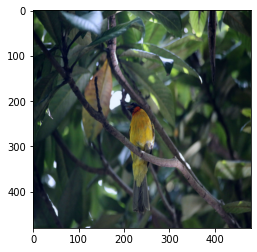

In [4]:
response = requests.get("https://dl.fbaipublicfiles.com/dino/img.png")
img0 = Image.open(BytesIO(response.content))
img0 = img0.convert('RGB')

plt.imshow(img0)
print(type(img0))
print(np.array(img0).shape)

## Get attention map

In [5]:
transform = pth_transforms.Compose([
    pth_transforms.ToTensor(),
    pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
img = transform(img0)
print(img.shape)

# make the image divisible by the patch size
w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
img = img[:, :w, :h].unsqueeze(0)

w_featmap = img.shape[-2] // patch_size
h_featmap = img.shape[-1] // patch_size

#attentions = model.forward_selfattention(img.to(device))
attentions = model.get_last_selfattention(img)   #img.cuda()
print(attentions.shape)


torch.Size([3, 480, 480])


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


torch.Size([1, 6, 901, 901])


In [6]:
print(dir(model))

['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_buffers', '_call_impl', '_forward_hooks', '_forward_pre_hooks', '_get_backward_hooks', '_get_name', '_init_weights', '_is_full_backward_hook', '_load_from_state_dict', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_members', '_non_persistent_buffers_set', '_parameters', '_register_load_state_dict_pre_hook', '_register_state_dict_hook', '_replicate_for_data_parallel', '_save_to_state_dict', '_slow_forward', '_state_dict_hooks', '_version', 'add_module', 'apply', 'bfloat16', 'blocks', 'buffers', 'chil

torch.Size([1, 3, 480, 480])
torch.Size([1, 384])


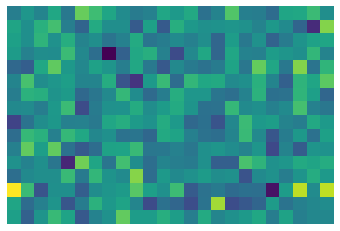

In [7]:
#output is not an attention image.
output=model(img)
print(img.shape)
print(output.shape)
plt.imshow(output.reshape(16,24))
plt.axis("off")
plt.show()

torch.Size([1, 3, 480, 480])
torch.Size([1, 6, 901, 901])


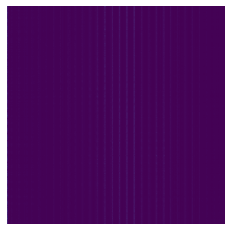

In [8]:
#get_last_selfattention
attentions = model.get_last_selfattention(img) 
print(img.shape)
print(attentions.shape)
plt.imshow(attentions[0][0].reshape(901,901))
plt.axis("off")
plt.show()

In [9]:
nh = attentions.shape[1] # number of head

# we keep only the output patch attention
attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
print(attentions.shape)

# we keep only a certain percentage of the mass
val, idx = torch.sort(attentions)
val /= torch.sum(val, dim=1, keepdim=True)
cumval = torch.cumsum(val, dim=1)

torch.Size([6, 900])


In [10]:
threshold = 0.6 # We visualize masks obtained by thresholding the self-attention maps to keep xx% of the mass.
th_attn = cumval > (1 - threshold)
idx2 = torch.argsort(idx)
for head in range(nh):
    th_attn[head] = th_attn[head][idx2[head]]
    
th_attn = th_attn.reshape(nh, w_featmap//2, h_featmap//2).float()

# interpolate
th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()

attentions = attentions.reshape(nh, w_featmap//2, h_featmap//2)
attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()
attentions_mean = np.mean(attentions, axis=0)

print(attentions.shape)

(6, 240, 240)


## Visualize Self-attention

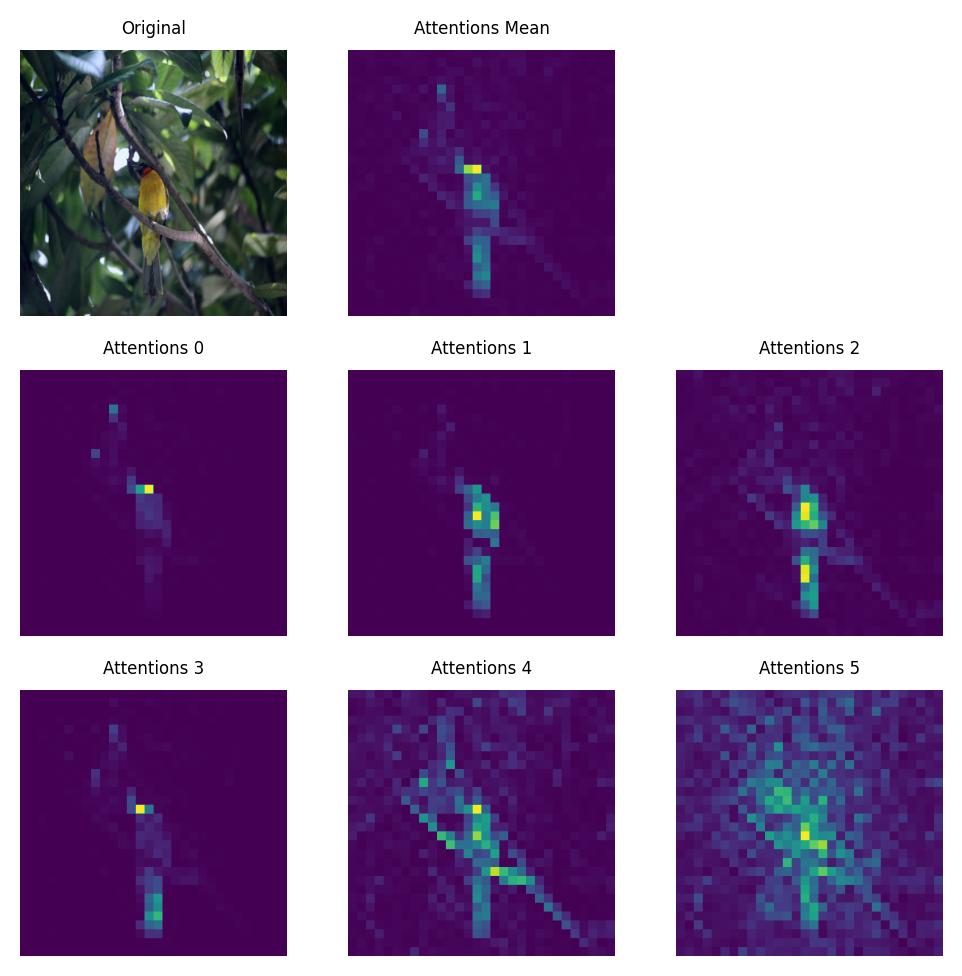

In [11]:
plt.figure(figsize=(6,6), dpi=200)

plt.subplot(3, 3, 1)
plt.title("Original",size=6)
plt.imshow(img0)
plt.axis("off")

plt.subplot(3, 3, 2)
plt.title("Attentions Mean",size=6)
plt.imshow(attentions_mean)
plt.axis("off")

for i in range(6):
    plt.subplot(3, 3, i+4)
    plt.title("Attentions "+str(i),size=6)
    plt.imshow(attentions[i])
    plt.axis("off")
